In [2]:
import os

import numpy as np
import pandas as pd

import json
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
timing_dir = '../eval_remote/analyze_outputs'
files = [os.path.abspath(os.path.join(timing_dir, f)) for f in os.listdir(timing_dir) if ('.json' in f) and any([(s in f) for s in ['row_icopy', 'row_ipush', 'col_icopy', 'col_copy']])]
files

['/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_col_icopy_iris5_15000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_row_icopy_iris4_15000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_row_icopy_iris3_10000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_row_ipush_iris4_1000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_row_ipush_iris3_1000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_row_icopy_iris5_1000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_row_ipush_iris5_15000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_col_copy_iris5_1000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_col_copy_iris5_20000000.json',
 '/Users/udeshuk/Developer/mldb/eval_remote/analyze_outputs/opt_vec_row_ipush_iris5_10000000.json',
 '/Use

In [9]:
times_raw = {}

for file in files:
    with open(file, "r") as f:
        name = file.split("/")[-1].split(".")[0]
        workload = name.split("_")[-1]
        key = name.split("_iris")[0]
        run = name.split("_iris")[1][0]
        times_raw[key + "~" + workload + "~" + run] = json.loads(f.read())

In [10]:
times = []

for k, v in times_raw.items():
    t = {}
    t['dataset'] = 'iris'
    t['pipeline'] = k.split("~")[0][8:]
    t['workload'] = k.split("~")[1]
    t['run'] = k.split("~")[2]

    if t['run'] ==  '1':
        prediction = v['children'][0]['children'][0]['children'][0]
    else:
        prediction = v['children'][0]['children'][0]
        # if t['pipeline'] == 'opt_vec2':
        #     print(t['workload'])
        #     pprint(prediction)
    pred_info = prediction['extra_info'].split('|')[1:]
    for i in pred_info:
        kv = i.split(":")
        t[kv[0]] = kv[1]
    
    times.append(t)

In [27]:
times_df = pd.DataFrame.from_records(times).loc[:, ['pipeline', 'workload', 'load', 'move', 'predict', 'move_rev']]
times_df = times_df.melt(id_vars=['pipeline', 'workload'], value_vars=['load', 'move', 'predict', 'move_rev'], var_name='phase', value_name='time')
times_df = times_df.sort_values(['pipeline', 'workload'])
times_df['time'] = times_df['time'].astype(int)

In [20]:
times_df

,pipeline,workload,phase,time
0,col_icopy,15000000,load,7043
1,row_icopy,15000000,load,6795
2,row_icopy,10000000,load,6575
3,row_ipush,1000000,load,7163
4,row_ipush,1000000,load,57895
...,...,...,...,...
235,row_icopy,15000000,move_rev,142383
236,col_icopy,15000000,move_rev,145621
237,row_ipush,10000000,move_rev,92283
238,col_copy,20000000,move_rev,235368


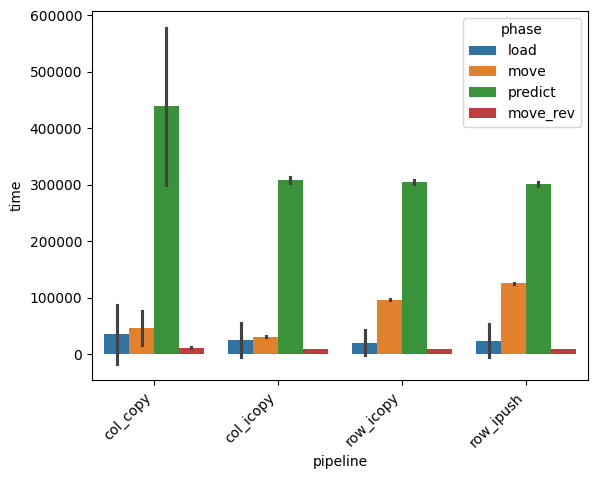

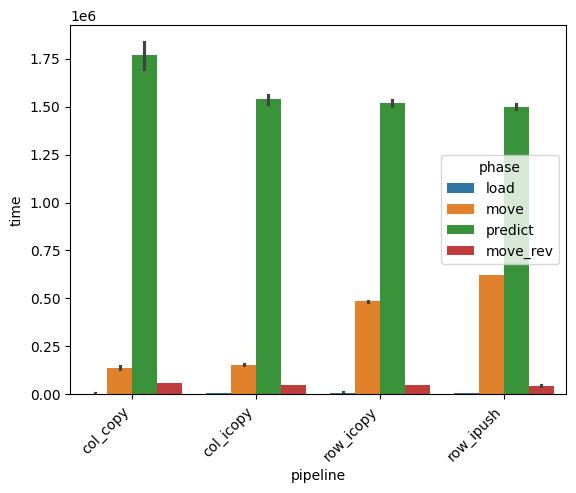

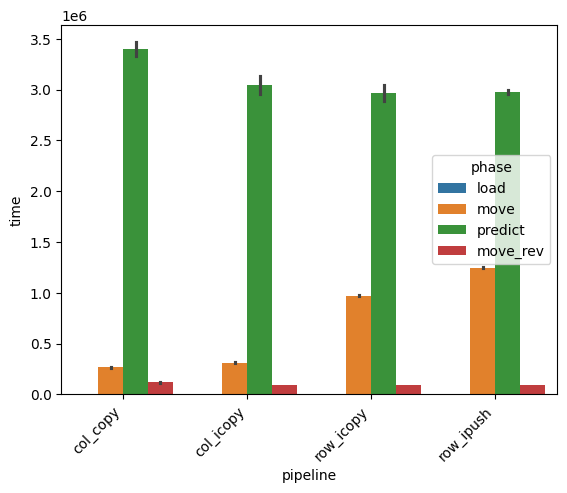

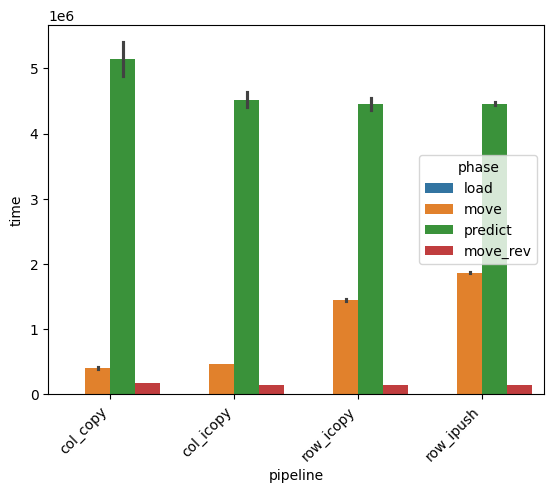

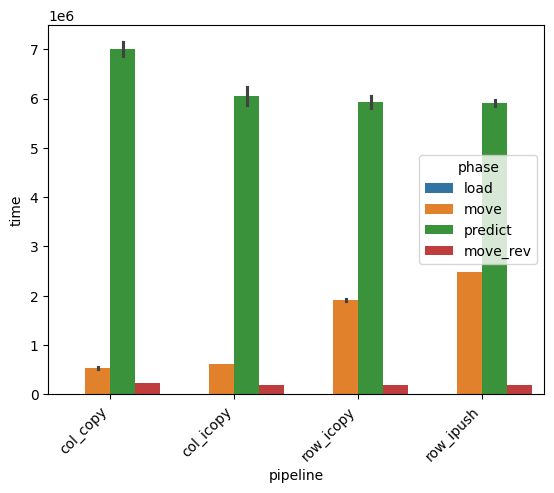

In [28]:
for w in ['1000000', '5000000', '10000000', '15000000', '20000000']:
    sns.barplot(times_df[times_df['workload'] == w], x="pipeline", y="time", hue="phase", errorbar='sd')
    plt.xticks(rotation=45, ha='right')
    plt.show()